In [5]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [6]:
BASE_DIR = Path("..")               # notebooks klasöründen proje köküne çıkar
PROCESSED_DIR = BASE_DIR / "data" / "processed"

path = PROCESSED_DIR / "districts_features_v2_model.csv"
path


WindowsPath('../data/processed/districts_features_v2_model.csv')

In [7]:
df = pd.read_csv(path)
df.shape, df.head()


((929, 11),
   province_name district_name        lat        lon   avg_temp  avg_rain  \
 0         Adana        Aladağ  37.666642  35.387781  16.739615       0.0   
 1         Adana        Ceyhan  37.011888  35.768198  19.804077       0.0   
 2         Adana          Feke  37.871495  35.821754  10.716615       0.0   
 3         Adana     Karaisali  37.259147  35.142888  12.239538       0.0   
 4         Adana       Karataş  36.675979  35.229132  21.450077       0.0   
 
    treecover_pct  potential_treecover_pct  missing_treecover_pct  \
 0          54.58                       10                   0.00   
 1           0.05                       10                   9.95   
 2          15.07                       10                   0.00   
 3           8.33                       10                   1.67   
 4           0.00                        5                   5.00   
 
    model_potential_treecover_pct  model_missing_treecover_pct  
 0                      44.543306          

In [8]:
df.columns


Index(['province_name', 'district_name', 'lat', 'lon', 'avg_temp', 'avg_rain',
       'treecover_pct', 'potential_treecover_pct', 'missing_treecover_pct',
       'model_potential_treecover_pct', 'model_missing_treecover_pct'],
      dtype='object')

In [9]:
feature_cols = ["avg_temp", "avg_rain"]
target_col = "treecover_pct"

train_df = df[df["missing_treecover_pct"] <= 5].copy()
train_df = train_df.dropna(subset=feature_cols + [target_col])

print("Train ilçe sayısı:", len(train_df))
train_df[[*feature_cols, target_col]].describe()


Train ilçe sayısı: 272


,avg_temp,avg_rain,treecover_pct
count,272.000000,272.0,272.000000
mean,12.768344,0.0,44.402684
std,3.593538,0.0,29.249909
min,4.144692,0.0,0.000000
25%,11.059462,0.0,18.497500
50%,13.289769,0.0,38.500000
75%,15.060692,0.0,71.380000
max,21.450077,0.0,98.720000


In [10]:
X = train_df[feature_cols].values
y = train_df[target_col].values

model = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)

def summarize(scores):
    return {"mean": float(np.mean(scores)), "std": float(np.std(scores))}

summary = {
    "train_mae": summarize(-cv_results["train_mae"]),
    "val_mae": summarize(-cv_results["test_mae"]),
    "train_rmse": summarize(-cv_results["train_rmse"]),
    "val_rmse": summarize(-cv_results["test_rmse"]),
    "train_r2": summarize(cv_results["train_r2"]),
    "val_r2": summarize(cv_results["test_r2"]),
}
summary


{'train_mae': {'mean': 13.464888981185965, 'std': 0.8154029299506879},
 'val_mae': {'mean': 21.84116362037732, 'std': 2.588171075770215},
 'train_rmse': {'mean': 17.464091073410223, 'std': 0.8993750782797697},
 'val_rmse': {'mean': 27.52170349253176, 'std': 3.3756929000107267},
 'train_r2': {'mean': 0.640482546619789, 'std': 0.041404869688389564},
 'val_r2': {'mean': 0.06363493321808904, 'std': 0.26781070520677586}}

In [11]:
model.fit(X, y)

X_all = df[feature_cols].values
pred = model.predict(X_all)

pred = np.clip(pred, 0, 100)

df["pred_treecover_pct"] = pred
df["treecover_gap_pct"] = np.maximum(df["pred_treecover_pct"] - df["treecover_pct"], 0)

df[["province_name","district_name","treecover_pct","pred_treecover_pct","treecover_gap_pct"]].head(10)


,province_name,district_name,treecover_pct,pred_treecover_pct,treecover_gap_pct
0,Adana,Aladağ,54.58,45.610237,0.000000
1,Adana,Ceyhan,0.05,37.492598,37.442598
2,Adana,Feke,15.07,27.646413,12.576413
3,Adana,Karaisali,8.33,18.054020,9.724020
4,Adana,Karataş,0.00,3.663069,3.663069
5,Adana,Kozan,0.59,45.610237,45.020237
6,Adana,Pozantı,4.73,18.054020,13.324020
7,Adana,Saimbeyli,43.16,39.014285,0.000000
8,Adana,Seyhan,0.00,37.492598,37.492598
9,Adana,Tufanbeyli,0.00,44.963322,44.963322


In [12]:
top20 = df.sort_values("treecover_gap_pct", ascending=False).head(20)
top20[["province_name","district_name","avg_temp","avg_rain","treecover_pct","pred_treecover_pct","treecover_gap_pct"]]


,province_name,district_name,avg_temp,avg_rain,treecover_pct,pred_treecover_pct,treecover_gap_pct
167,Bilecik,Osmaneli,12.633231,0.0,0.15,84.228454,84.078454
214,Bursa,Mudanya,15.650846,0.0,0.22,82.667252,82.447252
854,Van,Başkale,6.438385,0.0,0.00,79.073292,79.073292
300,Erzurum,Köprüköy,6.394385,0.0,0.00,79.073292,79.073292
305,Erzurum,Pasinler,6.394385,0.0,0.00,79.073292,79.073292
43,Agri,Hamur,6.332769,0.0,0.00,79.073292,79.073292
46,Agri,Taşlıçay,6.332769,0.0,0.00,79.073292,79.073292
792,Sivas,Koyulhisar,6.702692,0.0,0.00,78.557162,78.557162
356,Gümüshane,Şiran,6.610846,0.0,0.00,78.557162,78.557162
695,Ordu,Mesudiye,6.702692,0.0,0.00,78.557162,78.557162


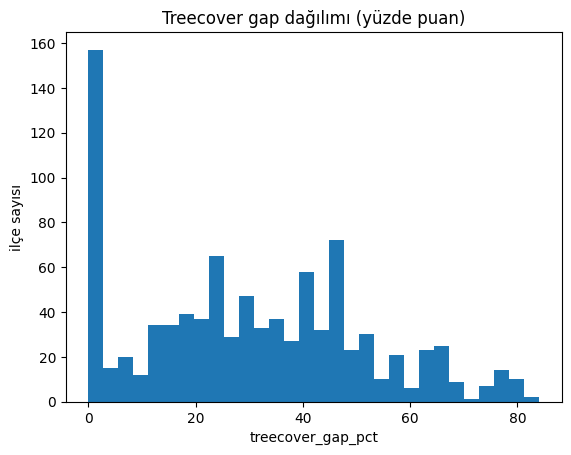

In [13]:
plt.figure()
plt.hist(df["treecover_gap_pct"], bins=30)
plt.title("Treecover gap dağılımı (yüzde puan)")
plt.xlabel("treecover_gap_pct")
plt.ylabel("ilçe sayısı")
plt.show()


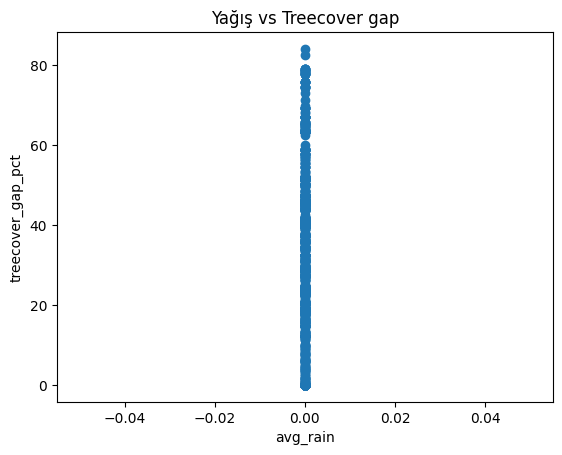

In [14]:
plt.figure()
plt.scatter(df["avg_rain"], df["treecover_gap_pct"])
plt.title("Yağış vs Treecover gap")
plt.xlabel("avg_rain")
plt.ylabel("treecover_gap_pct")
plt.show()


In [15]:
out_path = PROCESSED_DIR / "districts_features_v3_predictions.csv"
df.to_csv(out_path, index=False)
out_path


WindowsPath('../data/processed/districts_features_v3_predictions.csv')

In [16]:
def climate_bucket(row):
    if row["avg_rain"] < df["avg_rain"].quantile(0.33):
        return "kurak"
    elif row["avg_rain"] > df["avg_rain"].quantile(0.66):
        return "nemli"
    return "orta"

df["rain_bucket"] = df.apply(climate_bucket, axis=1)

policy_table = (
    df.groupby("rain_bucket")["treecover_gap_pct"]
    .agg(["count","mean","median","max"])
    .sort_values("mean", ascending=False)
)

policy_table


,count,mean,median,max
rain_bucket,,,,
orta,929,30.21296,29.063543,84.078454


In [ ]:
## 2.3 – Modelleme Özeti

Bu adımda ilçe bazında mevcut treecover yüzdesini (treecover_pct) iklim değişkenleri (avg_temp, avg_rain) ile açıklayan bir RandomForest regresyon modeli eğitildi.

### Doğruluk (Cross Validation)
- 5-fold cross validation ile MAE, RMSE ve R² metrikleri hesaplandı.
- Bu metrikler modelin genellenebilirliğini gösterir.

### Tahmin ve Senaryo
- Tüm ilçeler için beklenen treecover (pred_treecover_pct) tahmin edildi.
- Ağaçlandırma ihtiyacı göstergesi olarak:
  **treecover_gap_pct = max(pred_treecover_pct - treecover_pct, 0)** üretildi.
- En yüksek gap değerine sahip ilçeler “öncelikli” olarak değerlendirildi.

### Politika / Çevresel Yorum
- İlçeler yağış düzeyine göre (kurak/orta/nemli) gruplandı.
- Kurak bölgelerde ağaçlandırma maliyeti ve sürdürülebilirliği daha zor olabileceği için tür seçimi, sulama ve yangın riski yönetimi önemlidir.
- Nemli/orta bölgelerde yüksek gap görülen alanlar daha hızlı kazanım potansiyeli sunabilir.

### Çıktı
- `data/processed/districts_features_v3_predictions.csv` kaydedildi.
